<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Hyperparameter Tuning

## *Data Science Unit 4 Sprint 2 Assignment 4*

## Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: <https://drive.google.com/file/d/1dfbAsM9DwA7tYhInyflIpZnYs7VT-0AQ/view> 

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.info())
print(df.describe())
df.describe(exclude='number')

In [0]:
#encode gender,partner,dependents,phoneservice,paperlessbilling,churn as 0 or 1

columns = ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']

for name in columns:
  print(name,':',df[name].unique())

In [0]:
import numpy as np
df['TotalCharges'] = df['TotalCharges'].replace(' ',np.nan)


In [0]:
df=df[df['TotalCharges'].notnull()]
df=df.reset_index()[df.columns]


In [0]:
no_i_service=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
              'StreamingTV','StreamingMovies']

for column in no_i_service:
  df[column] = df[column].replace({'No internet service':'No'})

In [0]:
df['MultipleLines']=df['MultipleLines'].replace({'No phone service':'No'})

In [0]:
two_options=['gender','Partner','Dependents','PhoneService','PaperlessBilling',
             'Churn','OnlineSecurity','OnlineBackup','DeviceProtection',
             'TechSupport','StreamingTV','StreamingMovies','MultipleLines']

for column in two_options:
  df[column] = df[column].replace({'Yes':1,'No':0})
  
df['gender']=df['gender'].replace({'Male':1,'Female':0})

In [0]:
whats_left=['InternetService','Contract','PaymentMethod']

df = pd.get_dummies(df,columns=whats_left)

In [0]:
df=df.drop(columns='customerID')

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [0]:
!pip install wrangle

In [23]:
from sklearn.preprocessing import MinMaxScaler
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live
x=df.drop(columns='Churn')
y=df['Churn']

scaler = StandardScaler()
x = scaler.fit_transform(x)
print(x)

[[-1.00943013 -0.44032709  1.03561683 ... -0.5253508   1.40476387
  -0.54360352]
 [ 0.99065797 -0.44032709 -0.9656081  ... -0.5253508  -0.71186341
   1.83957601]
 [ 0.99065797 -0.44032709 -0.9656081  ... -0.5253508  -0.71186341
   1.83957601]
 ...
 [-1.00943013 -0.44032709  1.03561683 ... -0.5253508   1.40476387
  -0.54360352]
 [ 0.99065797  2.27103902  1.03561683 ... -0.5253508  -0.71186341
   1.83957601]
 [ 0.99065797 -0.44032709 -0.9656081  ... -0.5253508  -0.71186341
  -0.54360352]]


In [0]:
inputs = x.shape[1]
epochs = 50
batch_size = 10

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(inputs,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model.fit(x,y,validation_split=0.33, epochs=epochs,batch_size=batch_size)

In [0]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test)

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


def create_model():
  model = Sequential()
  model.add(Dense(12, input_shape=(inputs,),activation='relu'))
  model.add(Dense(12, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=1)

param_grid={
    'batch_size':[10,20,40,60,80,100],
    'epochs':[20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train,y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/20
5274/5274 [==============================] - 0s 70us/step - loss: 2.1397 - acc: 0.4206
Epoch 2/20
5274/5274 [==============================] - 0s 23us/step - loss: 1.3367 - acc: 0.4433
Epoch 3/20
5274/5274 [==============================] - 0s 22us/step - loss: 1.1984 - acc: 0.4623
Epoch 4/20
5274/5274 [==============================] - 0s 21us/step - loss: 1.1048 - acc: 0.4772
Epoch 5/20
5274/5274 [==============================] - 0s 25us/step - loss: 1.0252 - acc: 0.4900
Epoch 6/20
5274/5274 [==============================] - 0s 22us/step - loss: 0.9616 - acc: 0.4956
Epoch 7/20
5274/5274 [==============================] - 0s 22us/step - loss: 0.9166 - acc: 0.5040
Epoch 8/20
5274/5274 [==============================] - 0s 22us/step - loss: 0.8713 - acc: 0.5123
Epoch 9/20
5274/5274 [==============================] - 0s 23us/step - loss: 0.8143 - acc: 0.5305
Epoch 10/20
5274/5274 [==============================] - 0s 22us/step - loss: 0.7993 - acc: 0.5267
Epoch 11/20
5274/52

In [0]:

param_grid={
    'batch_size':[10,20],
    'epochs':[20, 40, 60]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x,y)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 

In [0]:
!pip install talos

In [0]:
import talos
from keras.activations import relu, elu
'''Hyperparameter tune (at least) the following parameters:

    batch_size
    training epochs
    optimizer
    learning rate (if applicable to optimizer)
    momentum (if applicable to optimizer)
    activation functions
    network weight initialization
    dropout regularization
    number of neurons in the hidden layer
'''

def create_model(x_train,y_train,x_val,y_val,params):
  model = Sequential()
  model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],activation=params['activation']))
  model.add(Dropout(params['dropout']))
  model.add(Dense(params['second_neuron'], activation=params['last_activation']))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss=params['losses'],metrics=['accuracy'])
  
  history = model.fit(x_train,y_train,
                     validation_data=[x_val,y_val],
                     batch_size=params['batch_size'],
                     callbacks=[live()],
                     epochs=params['epochs'],
                     verbose=1)
  
  return history,model




In [0]:
from keras.layers import Dropout

# Keras items
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import binary_crossentropy

p={
    'batch_size':[10,20,40],
    'epochs':[20],
    'first_neuron':[5],
    'second_neuron':[5],
    'activation':[relu],
    'last_activation':[relu],
    'dropout':[0],
    #'optimizer':[Adam],
    'losses':[binary_crossentropy]    
}

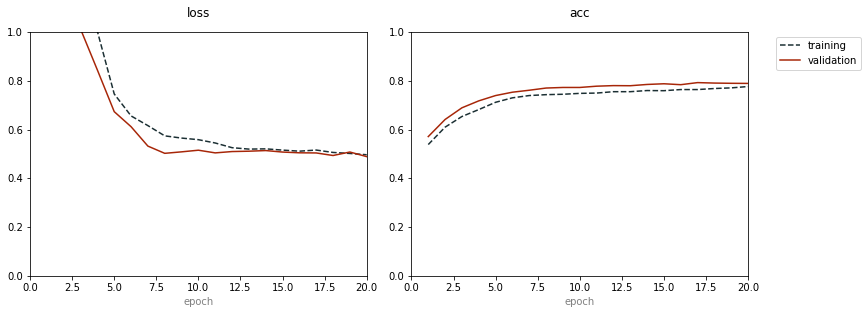






100%|██████████| 3/3 [00:54<00:00, 16.75s/it]






In [48]:
t = talos.Scan(x=x,
              y=y.values,
              model=create_model,
              params=p,
              dataset_name='churn',
              experiment_no='1')

In [49]:
t.data.head()

,round_epochs,val_loss,val_acc,loss,acc,batch_size,epochs,first_neuron,second_neuron,activation,last_activation,dropout,losses
0,20,0.486129,0.780095,0.495468,0.771841,40,20,5,5,<function relu at 0x7f2a04572bf8>,<function relu at 0x7f2a04572bf8>,0,<function binary_crossentropy at 0x7f2a045b8d08>
1,20,0.454187,0.801422,0.452563,0.787891,10,20,5,5,<function relu at 0x7f2a04572bf8>,<function relu at 0x7f2a04572bf8>,0,<function binary_crossentropy at 0x7f2a045b8d08>
2,20,0.488817,0.792417,0.496512,0.776310,20,20,5,5,<function relu at 0x7f2a04572bf8>,<function relu at 0x7f2a04572bf8>,0,<function binary_crossentropy at 0x7f2a045b8d08>


In [51]:
t.peak_epochs_df

,val_loss,val_acc,loss,acc,acc_epoch,loss_epoch
1,19,19,19,19,0.000857,0.019052
2,15,15,17,17,0.000083,0.006112
3,19,16,19,19,0.000048,0.003262


In [52]:
r = talos.Reporting(t)


<bound method Reporting.best_params of <talos.commands.reporting.Reporting object at 0x7f29e763bc88>>

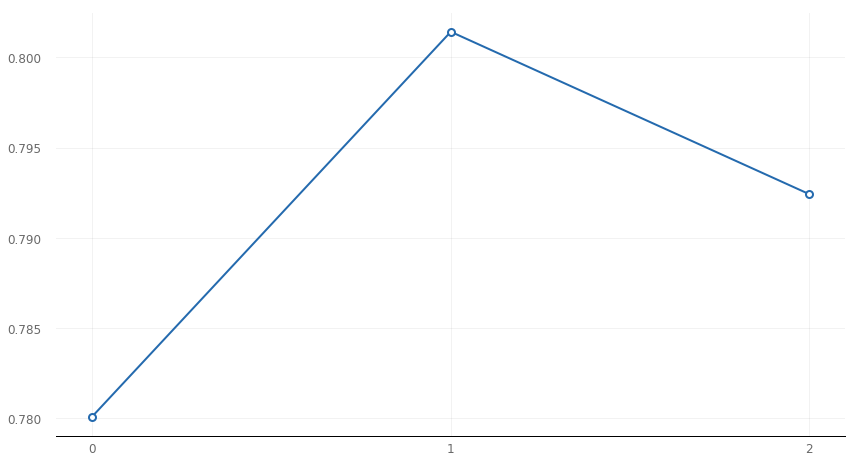

In [54]:
r.plot_line()

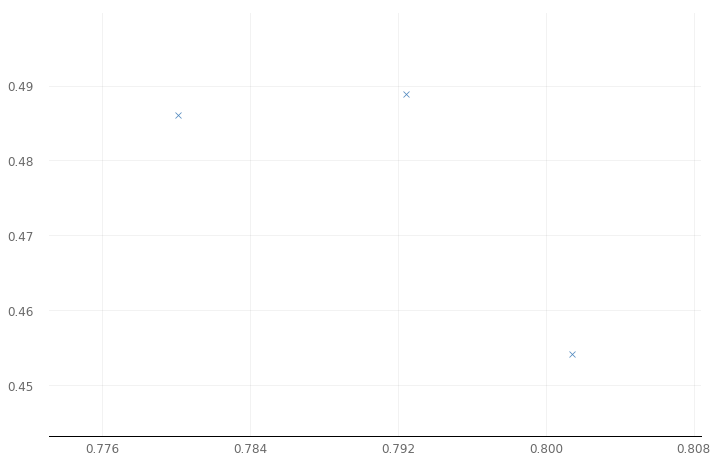

In [56]:
r.plot_regs()

In [57]:
r.best_params()

array([['<function relu at 0x7f2a04572bf8>', 20, 5, 5, 1,
        '<function binary_crossentropy at 0x7f2a045b8d08>', 0, 10,
        '<function relu at 0x7f2a04572bf8>', 0],
       ['<function relu at 0x7f2a04572bf8>', 20, 5, 5, 2,
        '<function binary_crossentropy at 0x7f2a045b8d08>', 0, 20,
        '<function relu at 0x7f2a04572bf8>', 1],
       ['<function relu at 0x7f2a04572bf8>', 20, 5, 5, 0,
        '<function binary_crossentropy at 0x7f2a045b8d08>', 0, 40,
        '<function relu at 0x7f2a04572bf8>', 2]], dtype=object)

In [61]:
r.correlate('val_loss')

batch_size       0.708407
epochs                NaN
first_neuron          NaN
second_neuron         NaN
dropout               NaN
NaN              0.069776
Name: val_loss, dtype: float64

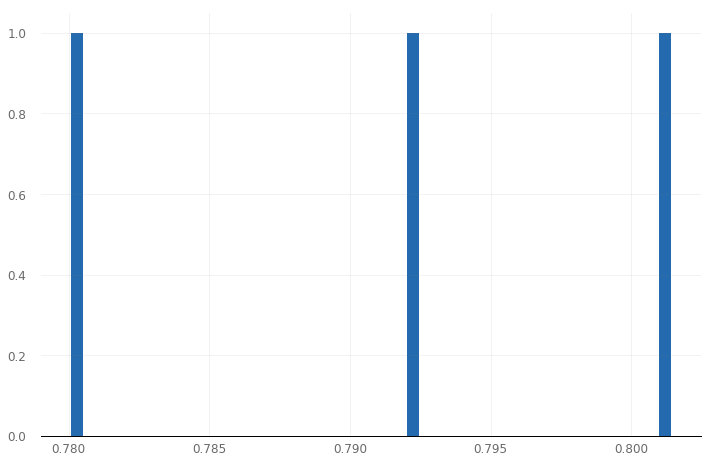

In [62]:
r.plot_hist(bins=50)

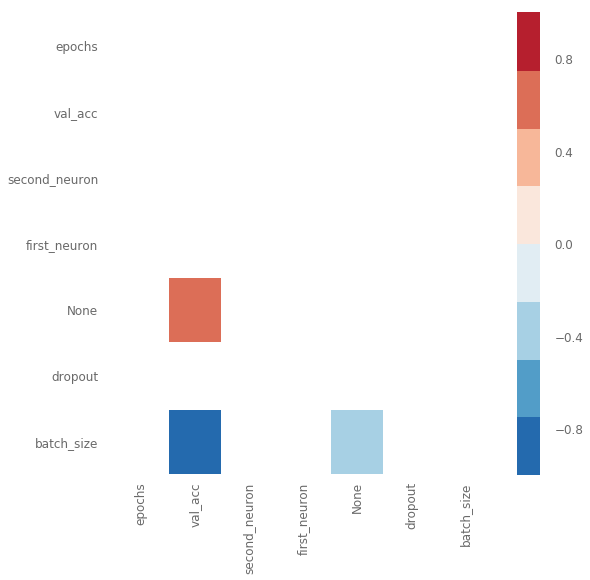

In [63]:
r.plot_corr()

## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?